In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor, export_text

pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

In [4]:
df = pd.read_pickle("all_tweets_v10.pkl")
df = df[df.tweet_type == "standard"]
df.head(3)

,author_id,context_annotations,conversation_id,created_at,edit_history_tweet_ids,id,in_reply_to_user_id,lang,possibly_sensitive,referenced_tweets,reply_settings,text,author,withheld,geo,quote_count,retweet_count,like_count,reply_count,impression_count,media_keys,poll_ids,hashtags,urls,mentions,cashtags,annotations,is_retweet,gender_of_author,profession_of_author,hashtags_flattened,trend_topics,n_trend_topics,text_length,has_media,has_hashtags,has_mentions,is_reply,tweet_type,ratio_like,ratio_retweet,majority_lang,english,universal,eng_astroturf,eng_fake_follower,eng_financial,eng_other,eng_overall,eng_self_declared,eng_spammer,uni_astroturf,uni_fake_follower,uni_financial,uni_other,uni_overall,uni_self_declared,uni_spammer,verified_author,followers_count_author,following_count_author,tweet_count_author,age_of_account_in_days_author,sentiment,created_at_day_of_week,created_at_month_of_year,created_at_time_of_day_in_seconds,reply_to_tweet_ratio,retweet_to_tweet_ratio,average_tweets_of_author_per_day,media_media_key_1,media_type_1,media_height_1,media_url_1,media_width_1,media_public_metrics_1,media_preview_image_url_1,media_duration_ms_1,media_alt_text_1,media_media_key_2,media_type_2,media_height_2,media_url_2,media_width_2,media_public_metrics_2,media_preview_image_url_2,media_duration_ms_2,media_alt_text_2,media_media_key_3,media_type_3,media_height_3,media_url_3,media_width_3,media_public_metrics_3,media_preview_image_url_3,media_duration_ms_3,media_alt_text_3,media_media_key_4,media_type_4,media_height_4,media_url_4,media_width_4,media_public_metrics_4,media_preview_image_url_4,media_duration_ms_4,media_alt_text_4,sttm_topic,political_context_annotation,created_at_year,created_at_time_of_day_in_seconds_sin,created_at_time_of_day_in_seconds_cos,n_media_keys,n_hashtags,n_urls,n_mentions,media_resolution_1,media_resolution_2,media_resolution_3,media_resolution_4
0,1449804331142811655,[],1617597872803041280,2023-01-23 18:59:21,[1617597872803041280],1617597872803041280,NaN,tr,False,NaN,everyone,"Kararlarındaki temel dayanak, hukukun evrensel...",Goksun_KHK,NaN,NaN,0,2,1,0,82,NaN,NaN,"[{'start': 95, 'end': 120, 'tag': 'OhalKomisyo...",NaN,NaN,NaN,NaN,0,ORG,NOT AVAILABLE,OhalKomisyonuHukuksuzdur,OhalKomisyonuHukuksuzdur,1,120,0,1,0,0,standalone,0.012195,0.024390,tr,0.874858,0.847463,0.13,0.51,0.22,0.91,0.91,0.08,0.25,0.12,0.44,0.1,0.87,0.87,0.19,0.16,False,1107.0,174.0,2962.0,470.0,0.994189,0,1,68361,0.013817,0.435233,1.231915,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,search for justice,False,2023,0.976296,0.216440,0.0,1,0,0,NaN,NaN,NaN,NaN
1,1449804331142811655,[],1617597646339702823,2023-01-23 18:58:27,[1617597646339702823],1617597646339702823,NaN,fr,False,NaN,everyone,#OhalKomisyonuHukuksuzdur https://t.co/3aUr5MZWPU,Goksun_KHK,NaN,NaN,0,1,0,0,52,[3_1617597636604723228],NaN,"[{'start': 0, 'end': 25, 'tag': 'OhalKomisyonu...","[{'start': 26, 'end': 49, 'url': 'https://t.co...",NaN,NaN,NaN,0,ORG,NOT AVAILABLE,OhalKomisyonuHukuksuzdur,OhalKomisyonuHukuksuzdur,1,49,1,1,0,0,standalone,0.000000,0.019231,tr,0.874858,0.847463,0.13,0.51,0.22,0.91,0.91,0.08,0.25,0.12,0.44,0.1,0.87,0.87,0.19,0.16,False,1107.0,174.0,2962.0,470.0,0.733746,0,1,68307,0.013817,0.435233,1.231915,3_1617597636604723228,photo,1600.0,https://pbs.twimg.com/media/FnLceudWABwBC4b.jpg,1600.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fr,False,2023,-0.537300,-0.843391,1.0,1,1,0,2560000.0,NaN,NaN,NaN
3,1449804331142811655,[],1617597543000440844,2023-01-23 18:58:02,[1617597543000440844],1617597543000440844,NaN,de,False,NaN,everyone,#OhalKomisyonuHukuksuzdur https://t.co/FHdc5DQ0u0,Goksun_KHK,NaN,NaN,1,1,1,0,86,[3_1617597534494392354],NaN,"[{'start': 0, 'end': 25, 'tag': 'OhalKomisyonu...","[{'start': 26, 'end': 49, 'url': 'https://t.co...",NaN,NaN,NaN,0,ORG,NOT AVAILABLE,OhalKomisyonuHukuksuz

# Preprocessing

## Column Types

In [46]:
irrelevant_columns = [
    "author_id",
    "conversation_id",
    "created_at",
    "edit_history_tweet_ids",
    "id",
    "in_reply_to_user_id",
    "referenced_tweets",
    "reply_settings",
    "text",  # incorporated with sentiment analysis, topic modelling
    "quote_count",
    "impression_count",
    "media_keys",  # Incorporated via n_media_keys
    "hashtags",
    "has_hashtags",
    "has_mentions",
    "urls",
    "mentions",
    "cashtags",
    "is_retweet",
    "ratio_like",
    "ratio_retweet",
    "hashtags_flattened",
    "trend_topics",
    "has_media",  # incorporated with n_media
    "is_reply",
    "tweet_type",
    "created_at_day_of_week",  # incorporated by cyclic features
    "created_at_month_of_year",  # incorporated by cyclic features
    "created_at_time_of_day_in_seconds",  # Incorporated by cyclic features
    "media_media_key_1",  # Incorporated via n_media_keys
    "media_media_key_2",  # Incorporated via n_media_keys
    "media_media_key_3",  # Incorporated via n_media_keys
    "media_media_key_4",  # Incorporated via n_media_keys
    "media_height_1",  # incorporated by resolution feature
    "media_height_2",  # incorporated by resolution feature
    "media_height_3",  # incorporated by resolution feature
    "media_height_4",  # incorporated by resolution feature
    "media_width_1",  # incorporated by resolution feature
    "media_width_2",  # incorporated by resolution feature
    "media_width_3",  # incorporated by resolution feature
    "media_width_4",  # incorporated by resolution feature
    "media_public_metrics_1",
    "media_public_metrics_2",
    "media_public_metrics_3",
    "media_public_metrics_4",
]

additional_irrelevant_columns = [
    # Bot score features
    "english",
    "universal",
    "eng_astroturf",
    "eng_fake_follower",
    "eng_financial",
    "eng_other",
    "eng_overall",
    "eng_self_declared",
    "eng_spammer",
    "uni_astroturf",
    "uni_fake_follower",
    "uni_financial",
    "uni_other",
    "uni_overall",
    "uni_self_declared",
    "uni_spammer",
]

# These columns are not available at prediction time
descriptive_columns = [
    "context_annotations",
    "possibly_sensitive",
    "withheld",
    "n_trend_topics",
    "annotations",
    "media_url_1",
    "media_url_2",
    "media_url_3",
    "media_url_4",
    "media_preview_image_url_1",
    "media_preview_image_url_2",
    "media_preview_image_url_3",
    "media_preview_image_url_4",
    "media_alt_text_1",
    "media_alt_text_2",
    "media_alt_text_3",
    "media_alt_text_4",
    "created_at_year",
]

is_exist_columns = [
    "geo",
    "poll_ids",
]


categorical_columns = [
    "lang",
    "author",  # TODO: investigate incorporating it as a categorical variable
    "gender_of_author",
    "profession_of_author",
    "majority_lang",
    "media_type_1",
    "media_type_2",
    "media_type_3",
    "media_type_4",
    "sttm_topic",
]

binary_columns = [
    "verified_author",
    "political_context_annotation",
]

target_columns = [
    "retweet_count",
    "like_count",
    "reply_count",
]

numerical_columns = [
    "text_length",
    "followers_count_author",
    "following_count_author",
    "tweet_count_author",
    "age_of_account_in_days_author",
    "sentiment",
    "reply_to_tweet_ratio",
    "retweet_to_tweet_ratio",
    "average_tweets_of_author_per_day",
    "media_duration_ms_1",
    "media_duration_ms_2",
    "media_duration_ms_3",
    "media_duration_ms_4",
    "created_at_time_of_day_in_seconds_sin",
    "created_at_time_of_day_in_seconds_cos",
    "n_media_keys",
    "n_hashtags",
    "n_urls",
    "n_mentions",
    "media_resolution_1",
    "media_resolution_2",
    "media_resolution_3",
    "media_resolution_4",
]

In [47]:
all_columns = (
    irrelevant_columns
    + additional_irrelevant_columns
    + descriptive_columns
    + is_exist_columns
    + categorical_columns
    + binary_columns
    + target_columns
    + numerical_columns
)
for column_name in all_columns:
    assert all_columns.count(column_name) == 1
assert set(all_columns) == set(df.columns)

## Preprocessing columns

In [48]:
preprocessed_df = df.copy()

In [49]:
preprocessed_df.drop(columns=irrelevant_columns, inplace=True)
preprocessed_df.drop(columns=descriptive_columns, inplace=True)
preprocessed_df.drop(columns=additional_irrelevant_columns, inplace=True)

In [50]:
preprocessed_df[is_exist_columns] = preprocessed_df[is_exist_columns].isna()
preprocessed_df[is_exist_columns].head()

,geo,poll_ids
0,True,True
1,True,True
3,True,True
5,True,True
6,True,True


In [51]:
preprocessed_df = pd.get_dummies(
    preprocessed_df, columns=categorical_columns, drop_first=True
)
preprocessed_df.head()

,geo,retweet_count,like_count,reply_count,poll_ids,text_length,verified_author,followers_count_author,following_count_author,tweet_count_author,age_of_account_in_days_author,sentiment,reply_to_tweet_ratio,retweet_to_tweet_ratio,average_tweets_of_author_per_day,media_duration_ms_1,media_duration_ms_2,media_duration_ms_3,media_duration_ms_4,political_context_annotation,created_at_time_of_day_in_seconds_sin,created_at_time_of_day_in_seconds_cos,n_media_keys,n_hashtags,n_urls,n_mentions,media_resolution_1,media_resolution_2,media_resolution_3,media_resolution_4,lang_art,lang_ca,lang_ckb,lang_cs,lang_cy,lang_da,lang_de,lang_el,lang_en,lang_es,lang_et,lang_eu,lang_fa,lang_fi,lang_fr,lang_hi,lang_ht,lang_hu,lang_hy,lang_in,lang_is,lang_it,lang_iw,lang_lt,lang_lv,lang_nl,lang_no,lang_pl,lang_pt,lang_qam,lang_qht,lang_qme,lang_qst,lang_ro,lang_ru,lang_sl,lang_sv,lang_tl,lang_tr,lang_und,lang_vi,lang_zxx,author_692khk,author_Adana_KHK,author_AfsinSuleyman,author_Afyon_KHK_,author_Ahmetli_KHK,author_Aksaray_KHK,author_Alper672Khk,author_Amasya_KHK05,author_Ankara_KHK,author_Askeriogrenci16,author_Aydin_KHK,author_AytenOzturke,author_Bafra_KHK,author_Balikesir_KHK,author_Basak__Demirtas,author_Batman_KHK,author_Bayburt_KHK,author_Bilecik_KHK,author_Bingol_KHK,author_Burdur_KHK,author_BursaGemlikKHK,author_BursaMKPasaKHK,author_Bursa_KHK,author_Canakkale_KHK,author_Cankaya_KHK,author_CerenKalay,author_CmrtesiAnneleri,author_Dbakir_KHK_21,author_Denizli_KHK,author_DrHabip,author_DursunA66065686,author_Duzce_KHK,author_Elazig_KHK,author_Elazig_KHK_23,author_EnesFreedom,author_ErdalEr76,author_EsitlikVeAdalet,author_Esitlikcikadin,author_Eskisehir_KHK,author_EzoOzer,author_FreeOsmanKavala,author_Gantep_KHK,author_Giresun_KHK,author_Goksun_KHK,author_Golbasi_KHK,author_Golmarmara_KHK,author_Hani_KHK,author_HastaTutuklular,author_Hatay_KHK,author_Isparta_KHK,author_KBGuclu,author_KHKAVRUPA,author_KHK_Akademi,author_KHK_ZONGULDAK,author_KMaras_KHK,author_KONYA_KHK_4242,author_KOU_Dayanisma,author_KSerefhanoglu,author_Karaman94836471,author_Kars_KHK,author_Kayseri_KHK,author_KeremALTIPARMAK,author_Kerem_khk,author_KeskinEren1,author_KhkAdiyaman,author_KhkSport,author_KirmiziSemsiyeD,author_Kirsehir_KHK,author_Kocaeli_KHK,author_Kutahya_KHK,author_LeventKenez,author_MSTanrikulu,author_MTanal,author_Malatya_KHK,author_Mamak_KHK,author_Manisa_KHK,author_Mardin_KHK,author_Mersin_KHK,author_Mihemed,author_MilenaBuyum,author_Mimozakadin,author_MstSelanik,author_Mus_KHK,author_Nazilli_KHK,author_Nesrinnas,author_Nigde_KHK,author_Nilufer_KHK,author_NuriyeGulmen,author_Ordu_KHK52,author_Osmangazi_KHK,author_Osmaniye_KHK,author_OzdemEsat,author_PinarTremblay,author_Pinar_Selek,author_PolatYamaner,author_RecepAt59386802,author_Refugee11move,author_Rize_KHK,author_SALIHBAYRAK7102,author_SaadetOzkanEfe,author_Sahinbey_Khk,author_Sakarya_KHK_54,author_Samsun_KHK,author_Samsun_KHK_55,author_SavlBirol,author_Sirnak_KHK,author_Sivas_KHK_5858,author_TTB_KHK,author_TarlabasiTM,author_TayipTemel,author_Tekirdag_KHK,author_Terme_khk,author_Tokat_KHK60,author_Trabzon_KHK_61,author_TurkishFacade,author_Turkiye_KHK,author_U_Hareketi,author_Urfa_KHK,author_Usak_KHK,author_VanKadinHaklari,author_Van_KHK,author_Vezirkopru_KHK,author_Yalova_KHK,author_Yozgat_KHK,author_YusufMetin_KHK,author__IHRAA,author_akin_birdal,author_amberinzaman,author_anlamiyoorsun,author_aratbaris_,author_ashabikhf,author_avcemilcicek,author_avsuphiozgen,author_aylajean,author_aysealtinay,author_baysal_nurcan,author_cahityildirm,author_cigdemkc,author_cirak_l,author_dbkadinhaklari,author_dogan_erbas44,author_e_erda,author_ehsane765,author_emavioglu,author_erzurum_khk,author_esik_platform,author_esitiz,author_etkinizab,author_feministgundem,author_ferhatttunc,author_gergerliogluof,author_gkursun,author_gulserenonanc,author_gursu_khk_bursa,author_hacerfoggo,author_havza_khk,author_hdpdemirtas,author_hlevci,author_ihd_genelmerkez,author_ihdcezaevi,author_ilkadim55_KHK,author_istanbul_KHK,author_istbar

In [52]:
# Impute columns with 0
media_columns_to_input = [
    f"{prefix}_{i}"
    for i in range(1, 5)
    for prefix in ["media_resolution", "media_duration_ms"]
]
for column in [
    "sentiment",
    "reply_to_tweet_ratio",
    "n_media_keys",
] + media_columns_to_input:
    preprocessed_df[column].fillna(0, inplace=True)

In [53]:
# preprocessed_df.dtypes

In [54]:
# Columns with missing values
for i in preprocessed_df[preprocessed_df.isna().any(axis=1)].isna().any().items():
    if i[1]:
        print(i[0])

In [55]:
preprocessed_df.shape

(91102, 350)

In [56]:
preprocessed_df.head()

,geo,retweet_count,like_count,reply_count,poll_ids,text_length,verified_author,followers_count_author,following_count_author,tweet_count_author,age_of_account_in_days_author,sentiment,reply_to_tweet_ratio,retweet_to_tweet_ratio,average_tweets_of_author_per_day,media_duration_ms_1,media_duration_ms_2,media_duration_ms_3,media_duration_ms_4,political_context_annotation,created_at_time_of_day_in_seconds_sin,created_at_time_of_day_in_seconds_cos,n_media_keys,n_hashtags,n_urls,n_mentions,media_resolution_1,media_resolution_2,media_resolution_3,media_resolution_4,lang_art,lang_ca,lang_ckb,lang_cs,lang_cy,lang_da,lang_de,lang_el,lang_en,lang_es,lang_et,lang_eu,lang_fa,lang_fi,lang_fr,lang_hi,lang_ht,lang_hu,lang_hy,lang_in,lang_is,lang_it,lang_iw,lang_lt,lang_lv,lang_nl,lang_no,lang_pl,lang_pt,lang_qam,lang_qht,lang_qme,lang_qst,lang_ro,lang_ru,lang_sl,lang_sv,lang_tl,lang_tr,lang_und,lang_vi,lang_zxx,author_692khk,author_Adana_KHK,author_AfsinSuleyman,author_Afyon_KHK_,author_Ahmetli_KHK,author_Aksaray_KHK,author_Alper672Khk,author_Amasya_KHK05,author_Ankara_KHK,author_Askeriogrenci16,author_Aydin_KHK,author_AytenOzturke,author_Bafra_KHK,author_Balikesir_KHK,author_Basak__Demirtas,author_Batman_KHK,author_Bayburt_KHK,author_Bilecik_KHK,author_Bingol_KHK,author_Burdur_KHK,author_BursaGemlikKHK,author_BursaMKPasaKHK,author_Bursa_KHK,author_Canakkale_KHK,author_Cankaya_KHK,author_CerenKalay,author_CmrtesiAnneleri,author_Dbakir_KHK_21,author_Denizli_KHK,author_DrHabip,author_DursunA66065686,author_Duzce_KHK,author_Elazig_KHK,author_Elazig_KHK_23,author_EnesFreedom,author_ErdalEr76,author_EsitlikVeAdalet,author_Esitlikcikadin,author_Eskisehir_KHK,author_EzoOzer,author_FreeOsmanKavala,author_Gantep_KHK,author_Giresun_KHK,author_Goksun_KHK,author_Golbasi_KHK,author_Golmarmara_KHK,author_Hani_KHK,author_HastaTutuklular,author_Hatay_KHK,author_Isparta_KHK,author_KBGuclu,author_KHKAVRUPA,author_KHK_Akademi,author_KHK_ZONGULDAK,author_KMaras_KHK,author_KONYA_KHK_4242,author_KOU_Dayanisma,author_KSerefhanoglu,author_Karaman94836471,author_Kars_KHK,author_Kayseri_KHK,author_KeremALTIPARMAK,author_Kerem_khk,author_KeskinEren1,author_KhkAdiyaman,author_KhkSport,author_KirmiziSemsiyeD,author_Kirsehir_KHK,author_Kocaeli_KHK,author_Kutahya_KHK,author_LeventKenez,author_MSTanrikulu,author_MTanal,author_Malatya_KHK,author_Mamak_KHK,author_Manisa_KHK,author_Mardin_KHK,author_Mersin_KHK,author_Mihemed,author_MilenaBuyum,author_Mimozakadin,author_MstSelanik,author_Mus_KHK,author_Nazilli_KHK,author_Nesrinnas,author_Nigde_KHK,author_Nilufer_KHK,author_NuriyeGulmen,author_Ordu_KHK52,author_Osmangazi_KHK,author_Osmaniye_KHK,author_OzdemEsat,author_PinarTremblay,author_Pinar_Selek,author_PolatYamaner,author_RecepAt59386802,author_Refugee11move,author_Rize_KHK,author_SALIHBAYRAK7102,author_SaadetOzkanEfe,author_Sahinbey_Khk,author_Sakarya_KHK_54,author_Samsun_KHK,author_Samsun_KHK_55,author_SavlBirol,author_Sirnak_KHK,author_Sivas_KHK_5858,author_TTB_KHK,author_TarlabasiTM,author_TayipTemel,author_Tekirdag_KHK,author_Terme_khk,author_Tokat_KHK60,author_Trabzon_KHK_61,author_TurkishFacade,author_Turkiye_KHK,author_U_Hareketi,author_Urfa_KHK,author_Usak_KHK,author_VanKadinHaklari,author_Van_KHK,author_Vezirkopru_KHK,author_Yalova_KHK,author_Yozgat_KHK,author_YusufMetin_KHK,author__IHRAA,author_akin_birdal,author_amberinzaman,author_anlamiyoorsun,author_aratbaris_,author_ashabikhf,author_avcemilcicek,author_avsuphiozgen,author_aylajean,author_aysealtinay,author_baysal_nurcan,author_cahityildirm,author_cigdemkc,author_cirak_l,author_dbkadinhaklari,author_dogan_erbas44,author_e_erda,author_ehsane765,author_emavioglu,author_erzurum_khk,author_esik_platform,author_esitiz,author_etkinizab,author_feministgundem,author_ferhatttunc,author_gergerliogluof,author_gkursun,author_gulserenonanc,author_gursu_khk_bursa,author_hacerfoggo,author_havza_khk,author_hdpdemirtas,author_hlevci,author_ihd_genelmerkez,author_ihdcezaevi,author_ilkadim55_KHK,author_istanbul_KHK,author_istbar

# Modelling

In [57]:
X = preprocessed_df[[c for c in preprocessed_df.columns if c not in target_columns]]
Y = preprocessed_df[[c for c in preprocessed_df.columns if c in target_columns]]

x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=0)

print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(68326, 347) (22776, 347) (68326, 3) (22776, 3)


In [58]:
def fit_and_evaluate(model_name, model_params):
    model_class, params = model_params
    model = model_class(**params)
    print("Training the model")
    model.fit(x_train, y_train.like_count)
    y_test_predicted = model.predict(x_test)

    print("Predicting with the trained model")

    mae = metrics.mean_absolute_error(y_test.like_count, y_test_predicted)
    mse = metrics.mean_squared_error(y_test.like_count, y_test_predicted)
    r2 = metrics.r2_score(y_test.like_count, y_test_predicted)

    print(f"The {model_name} model performance for testing set")
    print("--------------------------------------")
    print(f"MAE is {mae}")
    print(f"MSE is {mse}")
    print(f"R2 score is {r2}\n\n")
    return model

In [64]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

model_classes = {
    "decision_tree": (DecisionTreeRegressor, {}),
    "linear_regression": (LinearRegression, {}),
    "random_forest": (
        RandomForestRegressor,
        {"n_estimators": 2000, "random_state": 0, "n_jobs": -1},
    ),
}

In [65]:
models = {}
for model_name, params in model_classes.items():
    models[model_name] = fit_and_evaluate(model_name, params)

Training the model
Predicting with the trained model
The decision_tree model performance for testing set
--------------------------------------
MAE is 210.76567439409905
MSE is 1604733.636459431
R2 score is 0.1381121638275874


Training the model
Predicting with the trained model
The linear_regression model performance for testing set
--------------------------------------
MAE is 184.4044664510425
MSE is 950707.0387629826
R2 score is 0.4893838990742534


Training the model
Predicting with the trained model
The random_forest model performance for testing set
--------------------------------------
MAE is 169.60027485089824
MSE is 1039894.5913864251
R2 score is 0.4414820759942988




In [63]:
preprocessed_df.like_count.describe()

count    91102.000000
mean       220.721642
std       1330.305159
min          0.000000
25%          5.000000
50%         16.000000
75%         61.000000
max      73017.000000
Name: like_count, dtype: float64

<AxesSubplot: >

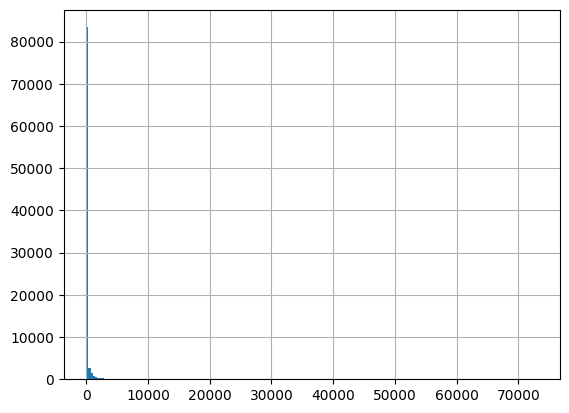

In [62]:
preprocessed_df.like_count.hist(bins=200)

# TODO

1. Outlier Detection
2. Different model architectures
3. Shapley values for black-box models

In [36]:
import numpy as np

importances = models["random_forest"].feature_importances_
std = np.std(
    [tree.feature_importances_ for tree in models["random_forest"].estimators_], axis=0
)

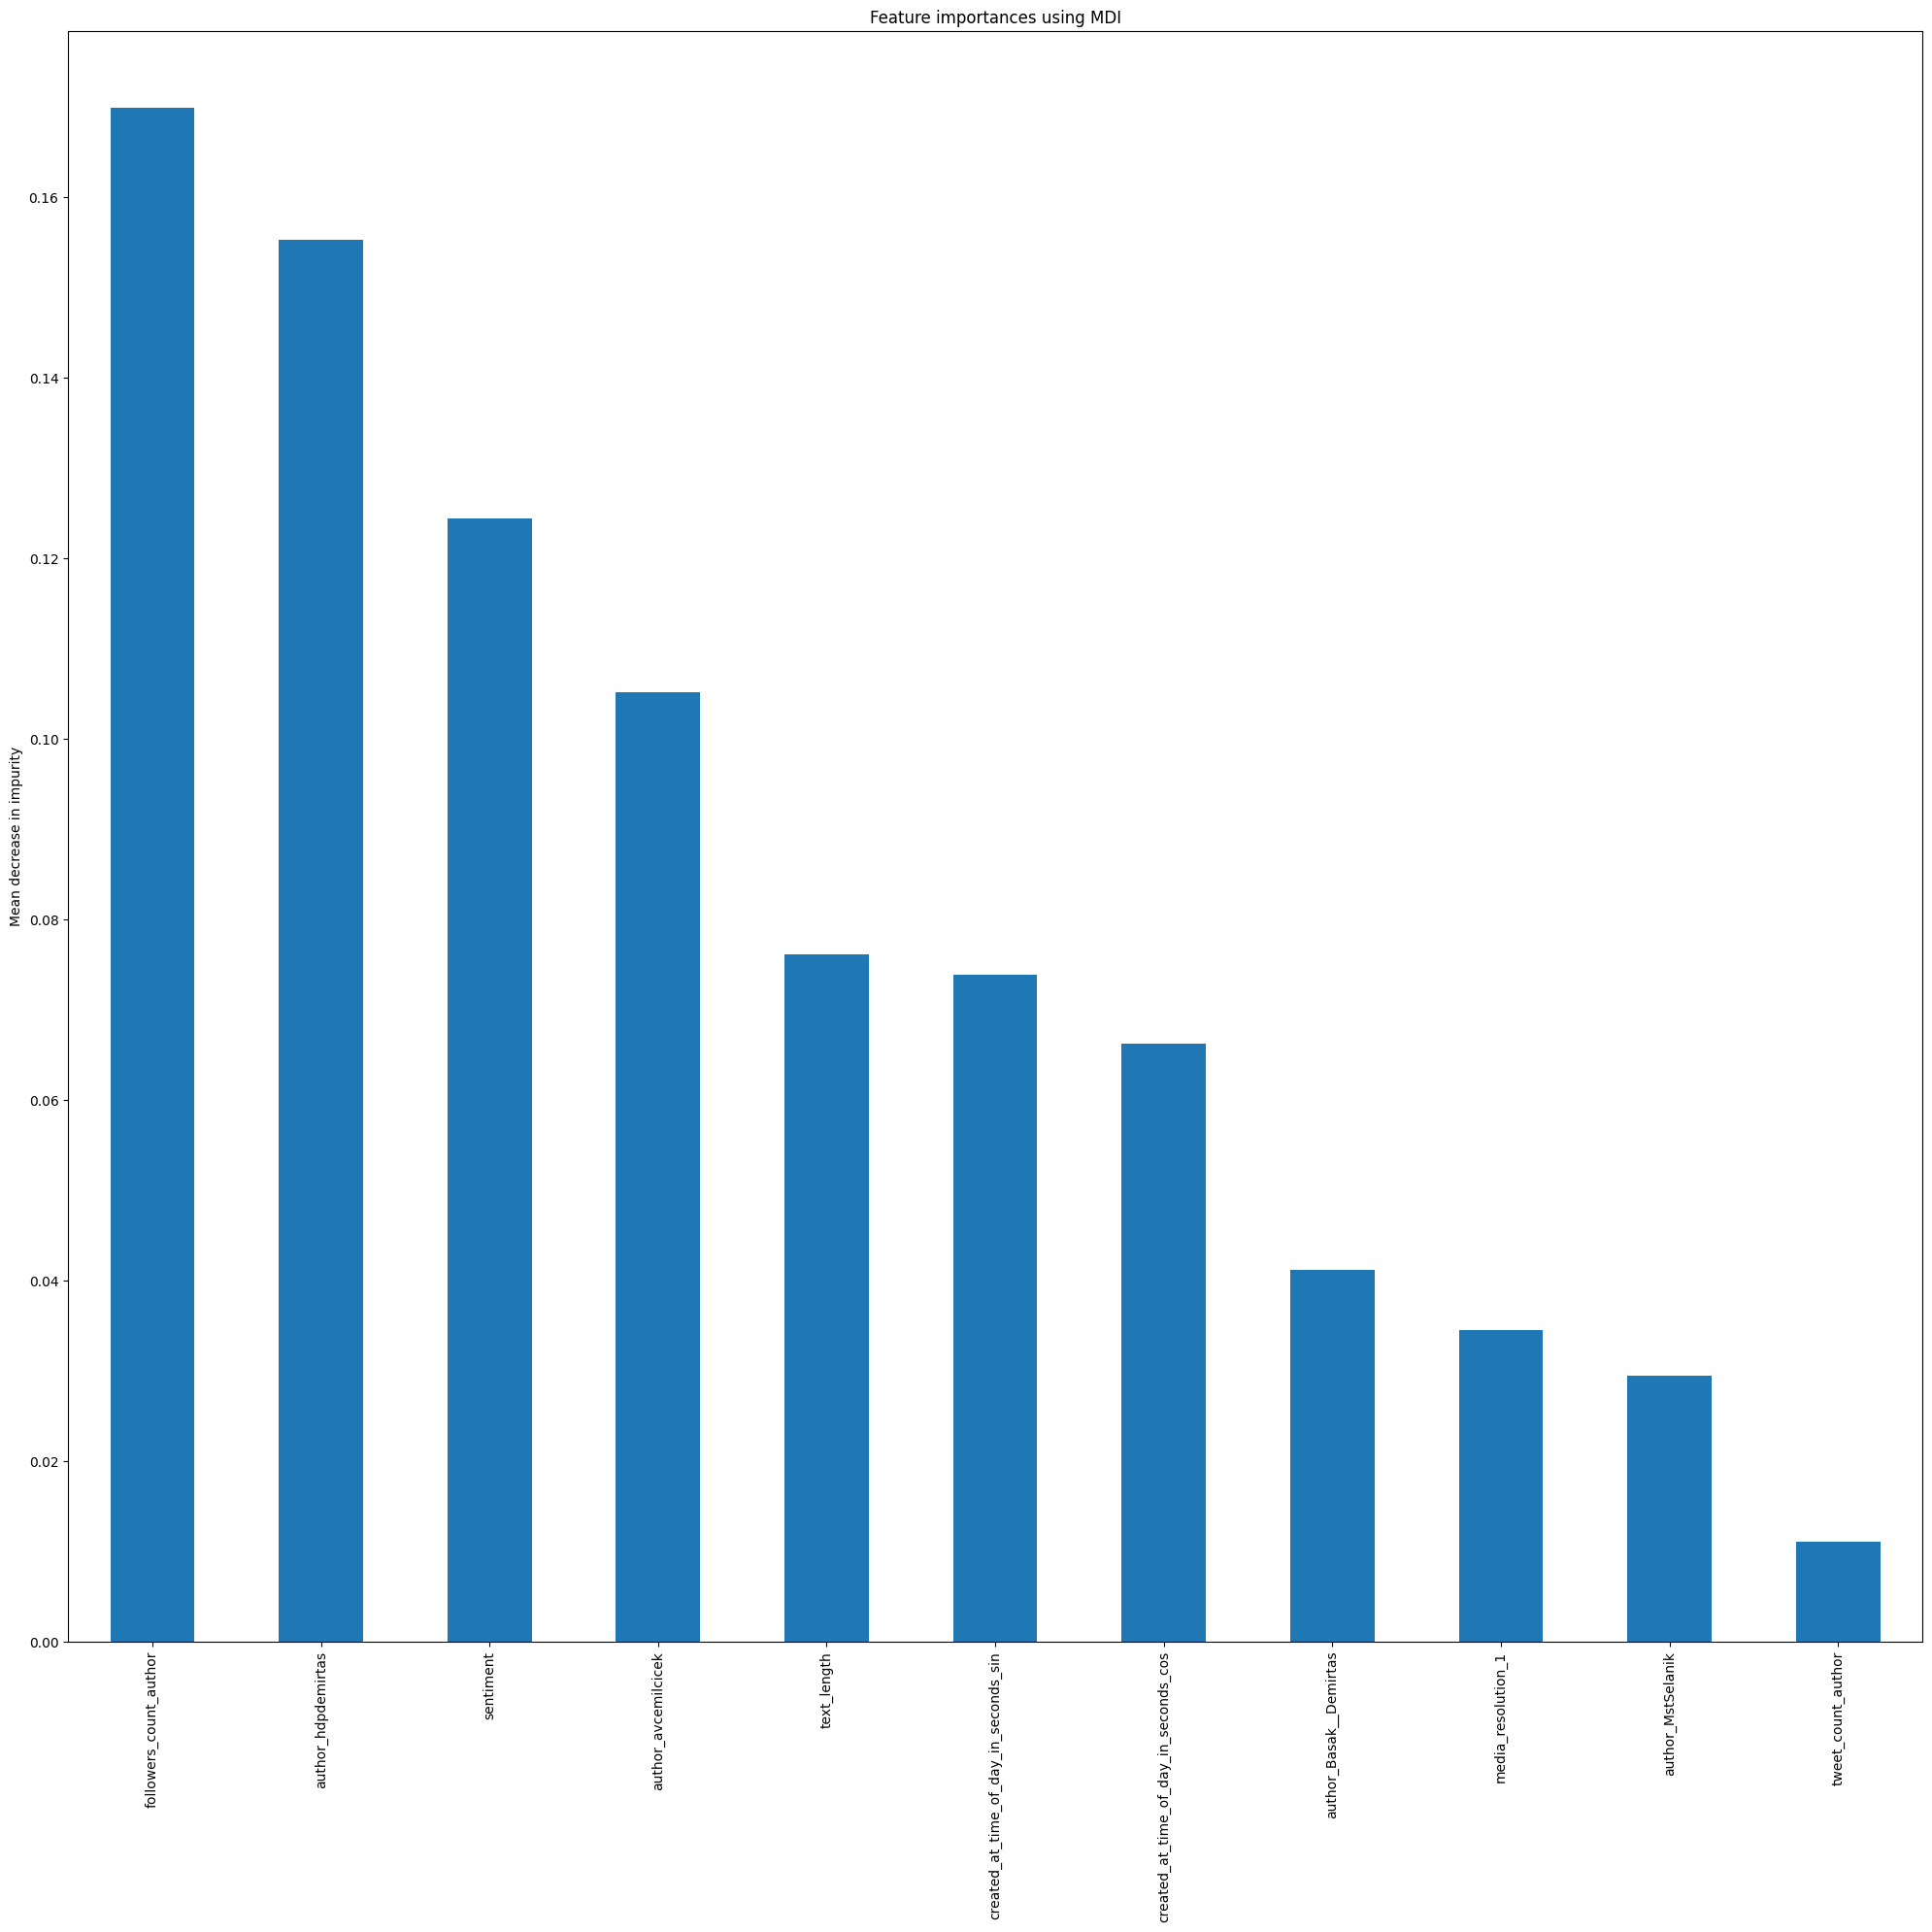

In [37]:
import pandas as pd

forest_importances = pd.Series(importances, index=X.columns)

filter_threshold = 0.01
filtered_importances = forest_importances[forest_importances > filter_threshold]
filtered_importances.sort_values(inplace=True, ascending=False)

fig, ax = plt.subplots(figsize=(20, 20))
filtered_importances.plot.bar(ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()
fig.savefig("feature_importances.png")  # save the figure to file

In [38]:
models.keys()

dict_keys(['decision_tree', 'linear_regression', 'random_forest'])

In [42]:
models["linear_regression"].coef_

# feature_names = models["linear_regression"].get_feature_names_out()
#
coefs = pd.DataFrame(
    models["linear_regression"].coef_,
    columns=["Coefficients"],
    index=models["linear_regression"].feature_names_in_,
)

coefs.sort_values(by="Coefficients")

,Coefficients
english,-4.044454e+08
author_TurkishFacade,-1.382039e+08
uni_fake_follower,-9.147412e+07
author__IHRAA,-6.664118e+07
author_Vezirkopru_KHK,-5.862585e+07
uni_other,-5.040683e+07
author_Kars_KHK,-3.799343e+07
author_Golbasi_KHK,-3.557841e+07
author_KHKAVRUPA,-3.226584e+07
author_Elazig_KHK,-3.187294e+07
